<a href="https://colab.research.google.com/github/sukritganesh/PytorchDemos/blob/main/Convolutional_Neural_Network_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification Using Convolutional Neural Network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the MNIST Dataset

Downloading the Dataset

In [9]:
# Image Transforms:
# First, convert images to tensor 
# Second, normalize (so that grayscale values are between -1 and 1 rather than 0 and 1)
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])

# Download the MNIST dataset, then apply the transforms
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Put data into DataLoader
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Convert Image to Denormalized Numpy Array 

In [10]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  
  # Denormalize
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)

  return image

Plotting some of our data

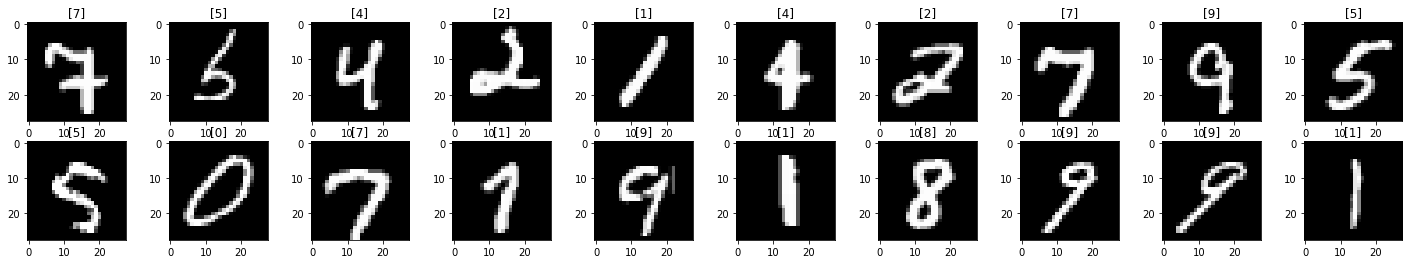

In [11]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title([labels[idx].item()])

# The Model

LeNet Model

In [12]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    # Convolutional Layers
    self.conv1 = nn.Conv2d(1, 20, 5, 1)   # 28 x 28 -> 24 x 24
    self.conv2 = nn.Conv2d(20, 50, 5, 1)  # 12 x 12 -> 8 x 8

    # Fully Connected Layers with Dropout Layer
    self.fc1 = nn.Linear(4*4*50, 500)     # 50 x (4 x 4 images) -> 500
    self.dropout1 = nn.Dropout(0.5)       
    self.fc2 = nn.Linear(500, 10)         # 500 -> 10 (digits)

  def forward(self, x):
    # Convolutional and Pooling Layers
    out = self.conv1(x)
    out = F.relu(out)
    out = F.max_pool2d(out, 2, 2)
    out = self.conv2(out)
    out = F.relu(out)
    out = F.max_pool2d(out, 2, 2)

    # Flatten out (so that it can be passed through fully connected layers)
    out = out.view(-1, 4*4*50)

    # Fully Connected Layers
    out = self.fc1(out)
    out = F.relu(out)
    out = self.dropout1(out)
    out = self.fc2(out)

    return out


Creating the model, criterion, and optimizer

In [13]:
model = LeNet().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


# Training the Neural Network

In [14]:
epochs = 15

training_loss_history = []
training_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):

  training_running_loss = 0.0
  training_running_correct = 0.0

  for inputs, labels in training_loader:
    # Utilize CUDA
    inputs = inputs.to(device)
    labels = labels.to(device)

    # feed forward
    model.train()   # set model to training mode
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # back propogate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # add current batch's loss to current epoch's total loss
    training_running_loss += loss.item()

    # add the current batch's number of correct predictions to running_correct
    _, preds = torch.max(outputs, 1)
    training_running_correct += torch.sum(preds == labels.data).item()

  else:
    # After epoch, feed validation data through model and record loss and accuracy
    # No need to keep track of gradients, so we set torch.no_grad() to save memory

    val_running_loss = 0.0
    val_running_correct = 0.0

    model.eval()    # set model to eval mode (will be useful later)
    with torch.no_grad():
      ct = 0
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_preds == val_labels.data).item()

    # bookkeeping: record loss, accuracy for train, validation data
    training_avg_epoch_loss = training_running_loss / len(training_loader.dataset)
    training_epoch_accuracy = training_running_correct / len(training_loader.dataset)
    training_loss_history.append(training_avg_epoch_loss)
    training_accuracy_history.append(training_epoch_accuracy)

    val_avg_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_accuracy = val_running_correct / len(validation_loader.dataset)
    val_loss_history.append(val_avg_epoch_loss)
    val_accuracy_history.append(val_epoch_accuracy)

    print('Epoch: {}/{}'.format(epoch+1, epochs))
    print('Training Loss: {: 4f}'.format(training_avg_epoch_loss), '| Training Accuracy: {:4f}'.format(training_epoch_accuracy))
    print('Validation Loss: {: 4f}'.format(val_avg_epoch_loss), '| Validation Accuracy: {:4f}'.format(val_epoch_accuracy))
    print()


Epoch: 1/15
Training Loss:  0.005697 | Training Accuracy: 0.848317
Validation Loss:  0.001481 | Validation Accuracy: 0.957900

Epoch: 2/15
Training Loss:  0.001460 | Training Accuracy: 0.956900
Validation Loss:  0.000848 | Validation Accuracy: 0.974300

Epoch: 3/15
Training Loss:  0.000982 | Training Accuracy: 0.970833
Validation Loss:  0.000625 | Validation Accuracy: 0.980100

Epoch: 4/15
Training Loss:  0.000771 | Training Accuracy: 0.976883
Validation Loss:  0.000491 | Validation Accuracy: 0.985400

Epoch: 5/15
Training Loss:  0.000632 | Training Accuracy: 0.981000
Validation Loss:  0.000414 | Validation Accuracy: 0.986500

Epoch: 6/15
Training Loss:  0.000563 | Training Accuracy: 0.982733
Validation Loss:  0.000366 | Validation Accuracy: 0.987900

Epoch: 7/15
Training Loss:  0.000494 | Training Accuracy: 0.985250
Validation Loss:  0.000324 | Validation Accuracy: 0.989400

Epoch: 8/15
Training Loss:  0.000446 | Training Accuracy: 0.986533
Validation Loss:  0.000310 | Validation Accu

Plotting the results.

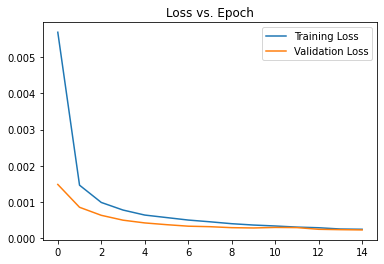

In [15]:
plt.plot(training_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.legend()

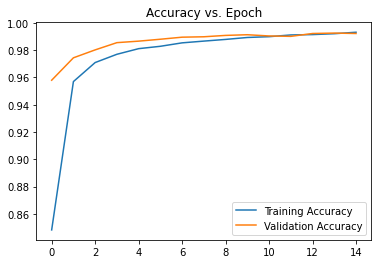

In [16]:
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

# Testing the Model

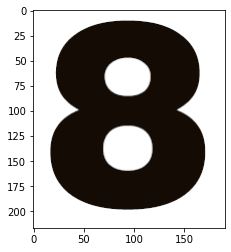

In [32]:
import requests
import PIL.ImageOps
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/ef502250-7ff3-4577-9d2c-b44694915788/svn/architectural-mailboxes-house-letters-numbers-3582b-5-64_145.jpg'
url = 'https://hianz.wrdp.com.au/wp-content/uploads/2018/12/613528304.jpg'
# url = input('Enter image URL: ')
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

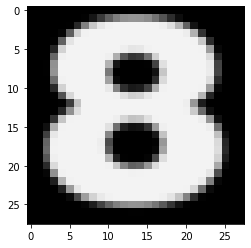

In [33]:
# Convert Image to Black & White
img = img.convert('L')

# Invert Colors (so that image has black background, white digit)
img = PIL.ImageOps.invert(img)

# Transform image (resize to 28x28, convert to torch.tensor, normalize)
# We already used this transform on the training and validation sets
img = transform(img)

plt.imshow(im_convert(img))

In [34]:
img = img.to(device)
img = img[0].unsqueeze(0).unsqueeze(0)
output = model(img)
_, pred = torch.max(output, 1)
print('Predicted digit:', pred.item())

Predicted digit: 8


Classifying 50 images from the 

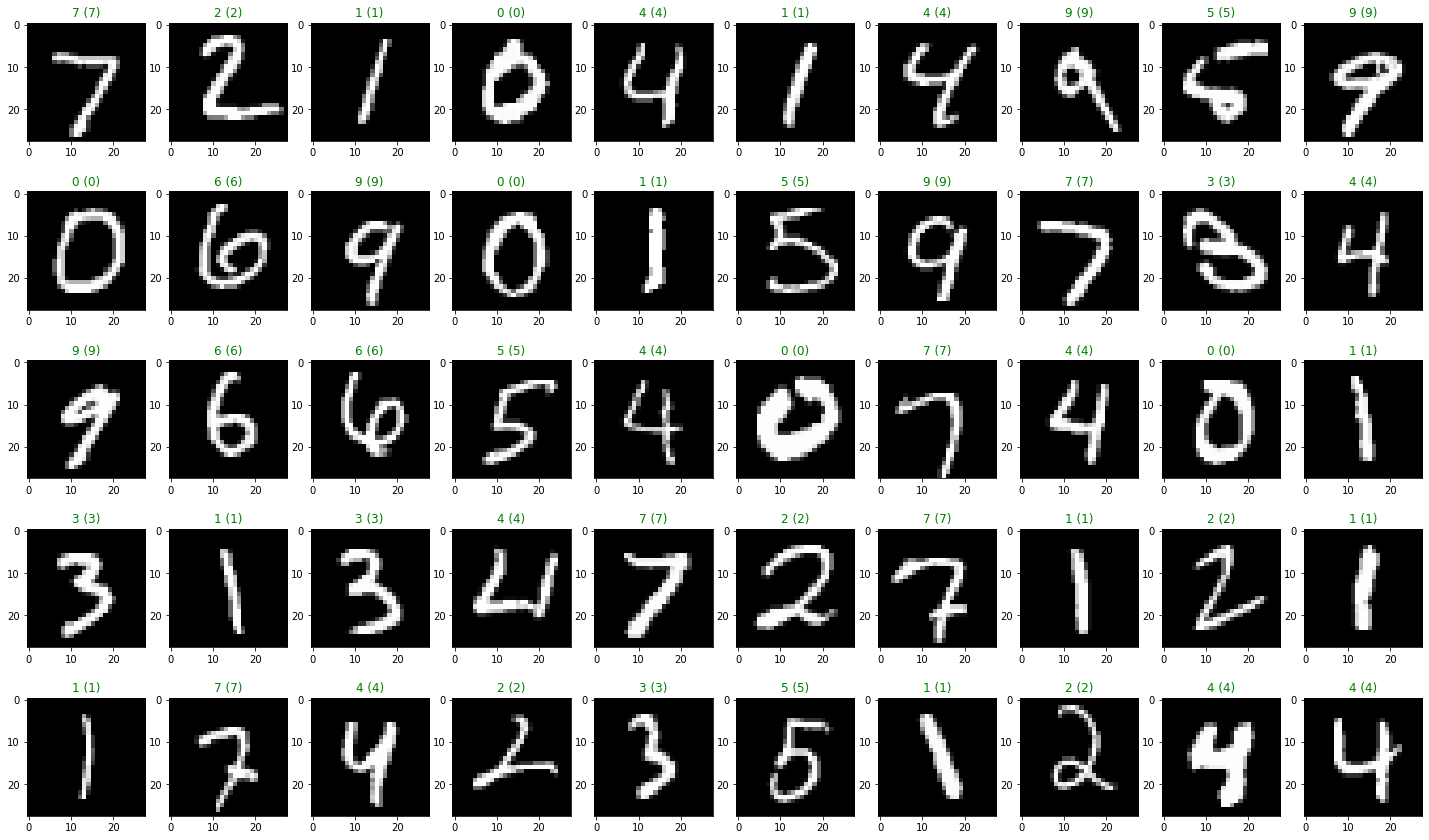

In [35]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()

images = images.to(device)
labels = labels.to(device)

model.eval()
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(25, 15))

for idx in np.arange(50):
  ax = fig.add_subplot(5, 10, idx+1)
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx]==labels[idx] else 'red'))

In [21]:
import numpy as np
import numpy.linalg as la

A = np.array([[5, 2], [2, 5]])
b = np.array([50, 41])
print(la.solve(A, b))

[8. 5.]
